# Cross-resonance gate between two transmons and a spectator.

In this notebook we study the cross-resonance two-qubit gate between two transmons and a third spectator transmon. 

In [27]:
import time
from collections import defaultdict
from itertools import product, combinations
from typing import List, Dict, Callable, Optional
from pathlib import Path
import copy
import json
import cmath

import numpy as np
import xarray as xr
import scipy.integrate
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from pysqkit import qubits, systems, couplers, drives, solvers, util
from util_cr import single_qubit_corrections, energy_levels_diagram

import pysqkit.util.transformations as trf
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit.util.linalg import get_mat_elem
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.tomography import TomoEnv

from pysqkit.solvers.solvkit import integrate
from pysqkit.solvers import solvkit

from IPython.display import display, Latex

In [28]:
SOLVER_OPTIONS = qtp.solver.Options()
SOLVER_OPTIONS.atol = 1e-12
SOLVER_OPTIONS.rtol = 1e-10

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H_c + H_t + V + H_{drive},$$

$$H_{\alpha} =  \hbar \omega_{\alpha} \hat{b}_{\alpha}^{\dagger}\hat{b}_{\alpha} + \hbar \frac{\delta_{\alpha}}{2} \hat{b}_{\alpha}^{\dagger} \hat{b}_{\alpha}^{\dagger}\hat{b}_{\alpha} \hat{b}_{\alpha}, \quad \alpha=t, c,$$

$$V = J_C \cdot \hat{q}_{1} \cdot \hat{q}_2,$$

$$\frac{H_{drive}}{h} = \left( \varepsilon_c \hat{q}_c + \varepsilon_t \hat{q}_t \right) \cos(2\pi f_d t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_{\alpha} = i \biggl( \frac{E_{J, \alpha}}{32 |\delta_{\alpha} |} \biggr)^{1/4} (b_{\alpha}^{\dagger} - b_{\alpha}),
$$
where 
$$
E_{\alpha} = \hbar \biggl(\frac{\omega_{\alpha} - \delta_{\alpha}}{8 | \delta_{\alpha} |} \biggr)^2.
$$

In the following we introduce relaxation due to dielectric loss and pure dephasing on each qubit as error channels. 

The idea behind the cross-resonance gate is to drive one of the qubit at the frequency of the other using the fact that due to the coupling we have a $XZ$ term in the Hamiltonian. 

# Define auxillary functions used

In [29]:
def comp_state_labels(num_qubits: Optional[int] = 2):
    state_combinations = product("01", repeat=num_qubits)
    labels = ["".join(states) for states in state_combinations]
    return labels

def state_labels(*qubit_states):
    state_combinations = product(*qubit_states)
    labels = ["".join(states) for states in state_combinations]
    return labels

def get_states(system, state_labels):
    states = {}
    for label in state_labels:
        _state = system.state(label)[1]
        
        loc = np.argmax(np.abs(_state))
        phase = cmath.phase(_state[loc])
        
        states[label] = np.exp(-1j*phase) * _state
    return states

In [30]:
def extract_freqs(
    qubit: systems.Qubit, 
) -> Dict[str, float]:
    """
    Description
    --------------------------------------------------------------
    Returns the transition frequencies of a given qubit.
    """
    
    num_levels = qubit.dim_hilbert
    
    results = {}
    
    states = [qubit.state(str(level)) for level in range(num_levels)]
        
    for level_i, level_j in combinations(range(num_levels), 2):
        freq_i = states[level_i][0]
        freq_j = states[level_j][0]
        results[f"freq_{level_i}{level_j}"] = freq_j - freq_i

    return results

In [31]:
def zz_crosstalk(system: systems.QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def xz_coeff(comp_states, op) -> float:
    xz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    xz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(xz0 - xz1))/2

def xi_coeff(comp_states, op) -> float:
    xi0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    xi1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(xi0 + xi1))/2

In [32]:
def func_to_minimize(
    x: List[float],
    rise_time: float,
    amp: float
) -> float:
    pulse_time = x[0]
    time_step = 1e-3
    num_points = int(pulse_time/time_step)
    times = np.linspace(0, pulse_time, num_points)
    
    pulse = gaussian_top(times, rise_time, pulse_time)
    integral = scipy.integrate.simpson(2*np.pi*amp*pulse, times)
    return np.abs(integral - np.pi/4)  #Watch out factor of 2?  

In [33]:
def minimize_drive_time(
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    eps_drive : float,
    rise_time : Optional[float] = 5.0,
    *,
    init_time : Optional[float] = 100.0,
) -> float:
    
    q_op = system["control"].charge_op()
    args_to_pass = (rise_time, np.abs(xz_coeff(comp_states, q_op))*0.5*eps_drive)

    try:
        minimization_result = minimize(
            func_to_minimize, 
            init_time,
            args=args_to_pass
        )
        gate_time = minimization_result['x'][0]
    except ValueError:
        gate_time = None
    
    return gate_time

def get_drive_params(
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    eps_drive : float,
    rise_time : Optional[float] = 10.0,
    *,
    init_time : Optional[float] = 100.0,
    detuning : Optional[float] = 0,
    points_per_period : Optional[int] = 10
):
    pulse_time = minimize_drive_time(
        system = coupled_sys,
        comp_states = comp_states,
        eps_drive = eps_drive,
        rise_time = rise_time,
        init_time=init_time
    )
    
    if pulse_time is None:
        raise ValueError("Pulse time minimization has failed.") # Should be handled differently
    
    drive_freq = system["target"].freq
    
    num_points = int(pulse_time * drive_freq * points_per_period)
    times = np.linspace(0, pulse_time, num_points)

    params = dict(
        phase = 0, 
        time = times, 
        rise_time = rise_time, 
        pulse_time = pulse_time,
        amp = eps_drive, 
        freq = drive_freq + detuning
    )
    return params

In [34]:
def run_simulation(
    times: np.ndarray,
    system: systems.QubitSystem, 
    init_state: qtp.qobj.Qobj, 
    options: Optional[qtp.solver.Options] = None,
    *,
    solver="mesolve",
    with_noise: Optional[bool] = False
) -> qtp.solver.Result:
    sys_hamil = system.hamiltonian(as_qobj=True)
    drive_hamils = []
    drive_pulses = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                drive_hamils.append(drive.hamiltonian(as_qobj=True))
                drive_pulses.append(drive.eval_pulse())
    
    if with_noise:
        jump_ops = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
    else:
        jump_ops = []
                    
    result = integrate(
        times, 
        init_state, 
        sys_hamil, 
        drive_hamils,
        drive_pulses, 
        jump_ops, 
        solver=solver, 
        options=options
    )
                    
    return result  

In [35]:
def get_probabilities(
    state_labels : List[str], 
    system : systems.QubitSystem, 
    output_states : List[qtp.Qobj],
) -> Dict:
    probs_dict = {}
    
    for label in state_labels:
        probs = []
        
        state = system.state(label, as_qobj=True)[1]        
        projector = state*state.dag()
        
        for out_state in output_states:
            prob = qtp.expect(projector, out_state)
            probs.append(prob)
        
        probs_dict[label] = probs
    return probs_dict

In [36]:
def get_leakage(
    times: np.ndarray,
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    options: Optional[qtp.solver.Options] = None,
    *,
    with_noise: Optional[bool] = False
):
    env_syst = TomoEnv(
        system=system, 
        time=2*np.pi*times, 
        options=options, 
        with_noise=with_noise
    )
    
    leakage = env_syst.leakage(comp_states)
    return leakage    

# Introducing the qubits and the coupled system

In [37]:
TEMPERATURE = 0.020
THERMAL_ENERGY = util.phys.temperature_to_thermalenergy(TEMPERATURE)

TRANSMON_LEVELS = 3
TRANSMON_ANHARM = -0.330
DIEL_LOSS_TANGENT = 3e-7

target_transmon = qubits.SimpleTransmon(
    label = 'target', 
    max_freq = 5.140, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

control_transmon = qubits.SimpleTransmon(
    label = 'control', 
    max_freq = 5.210, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

spec_transmon = qubits.SimpleTransmon(
    label = 'spectator', 
    max_freq = 4.950, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

In [38]:
# We also add a drive on the fluxonium
control_transmon.add_drive(
    drives.microwave_drive,
    label = 'cr_drive',
    pulse = drives.pulses.cos_modulation,
    pulse_shape = drives.pulse_shapes.gaussian_top
)

In [39]:
coup_strength = 0.001

control_spectator_coup = couplers.capacitive_coupling(
    qubits=[control_transmon, spec_transmon],
    strength=coup_strength,
)

target_control_coup = couplers.capacitive_coupling(
    qubits=[target_transmon, control_transmon],
    strength=coup_strength,
)

In [40]:
bare_sys = target_transmon.couple_to(
    control_transmon
)

coupled_sys = target_transmon.couple_to(
    control_transmon, 
    coupling=couplers.capacitive_coupling, 
    strength=coup_strength
)

full_sys = systems.QubitSystem(
    qubits=[target_transmon, control_transmon, spec_transmon],
    coupling=[target_control_coup, control_spectator_coup]
)

In [41]:
print(f"Driven system qubit order: {[q.label for q in coupled_sys.qubits]}")
print(f"Full system qubit order: {[q.label for q in full_sys.qubits]}")

Driven system qubit order: ['target', 'control']
Full system qubit order: ['target', 'control', 'spectator']


In [42]:
comp_states = get_states(coupled_sys, comp_state_labels(2))

In [43]:
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{kHz}}$'.format(1e6*zz_crosstalk(coupled_sys))))

<IPython.core.display.Latex object>

In [44]:
EPS_DRIVE = 0.02 #GHz
RISE_TIME = 10

drive_params = get_drive_params(
    system = coupled_sys,
    comp_states = comp_states,
    eps_drive = EPS_DRIVE,
    rise_time = RISE_TIME,
)
times =  drive_params["time"]
coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)

In [45]:
_, init_state = coupled_sys.state('11', as_qobj=True)

output = run_simulation(
    times = 2*np.pi*times,
    system = coupled_sys,
    init_state = init_state, 
    options = SOLVER_OPTIONS,
)

In [48]:
labels = ['00', '10', '20', '01', '01', '01', '11', '02']
eval_step = 50

eval_times = times[::eval_step]
output_states = output.states[::eval_step]

eval_probs = get_probabilities(
   state_labels = labels, 
    system = coupled_sys, 
    output_states = output.states[::eval_step], 
)

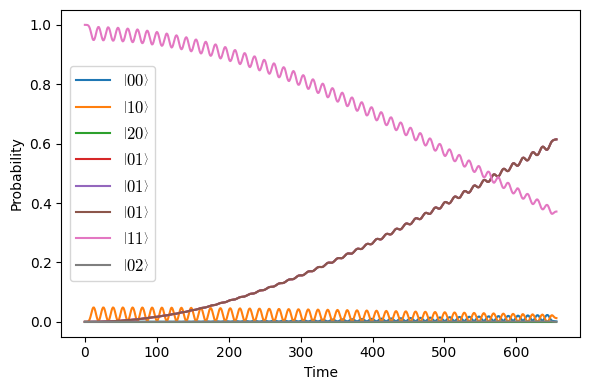

In [49]:
fig, ax = plt.subplots(dpi=100)

for ind, label in enumerate(labels):
    ax.plot(
        eval_times, 
        eval_probs[label], 
        label=f'$\\left|{label}\\right\\rangle$'
    )
    
plt.legend(fontsize=12)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()
plt.show()

In [50]:
expected_leakage_rate = get_leakage(
    times = times,
    system = coupled_sys,
    comp_states = list(comp_states.values()),
    options = SOLVER_OPTIONS,
    with_noise = False
)
print(expected_leakage_rate)

4.984801883711754e-06


# Probabilities involving spectator qubit

In [56]:
full_sys['control'].drives['cr_drive'].set_params(**drive_params)

In [57]:
_, init_state = full_sys.state('000', as_qobj=True)

output = run_simulation(
    times = 2*np.pi*times,
    system = full_sys,
    init_state = init_state, 
    options = SOLVER_OPTIONS,
)

In [58]:
labels = ["000", "001", "010", "011", "020", "021", "100", "101", "110", "111", "120", "121"]
eval_step = 50

eval_times = times[::eval_step]
output_states = output.states[::eval_step]

eval_probs = get_probabilities(
    state_labels = labels, 
    system = full_sys, 
    output_states = output.states[::eval_step], 
)

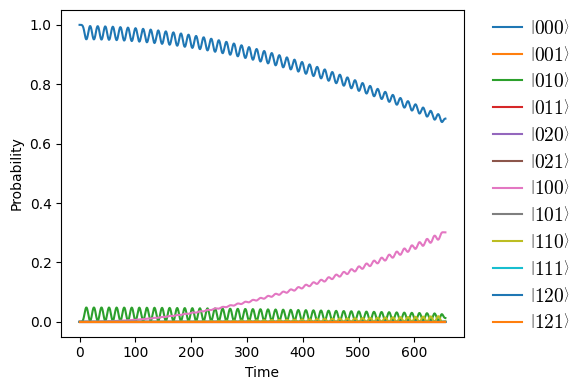

In [59]:
fig, ax = plt.subplots(dpi=100)

for ind, label in enumerate(labels):
    ax.plot(
        eval_times, 
        eval_probs[label], 
        label=f'$\\left|{label}\\right\\rangle$'
    )
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

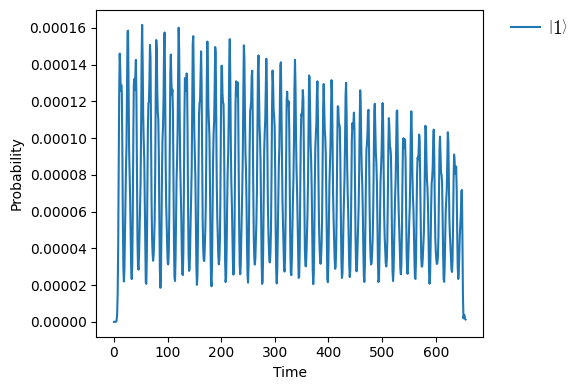

In [60]:
fig, ax = plt.subplots(dpi=100)

spec_state = "1"
spec_probs = np.zeros(len(eval_times), dtype=float)
for label in labels:
    if label[2] == spec_state:
        spec_probs += eval_probs[label]

ax.plot(
    eval_times, 
    spec_probs, 
    label=f'$\\left|{spec_state}\\right\\rangle$'
)
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(dpi=100)

control_state = "2"
control_probs = np.zeros(len(eval_times), dtype=float)
for label in labels:
    if label[1] == control_state:
        control_probs += eval_probs[label]

ax.plot(
    eval_times, 
    control_probs, 
    label=f'$\\left|{control_state}\\right\\rangle$'
)
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(dpi=100)

spec_state = "1"
spec_probs = np.zeros(len(eval_times), dtype=float)
for label in labels:
    if label[2] == spec_state:
        spec_probs += eval_probs[label]

ax.plot(
    eval_times, 
    spec_probs, 
    label=f'$\\left|{spec_state}\\right\\rangle$'
)
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

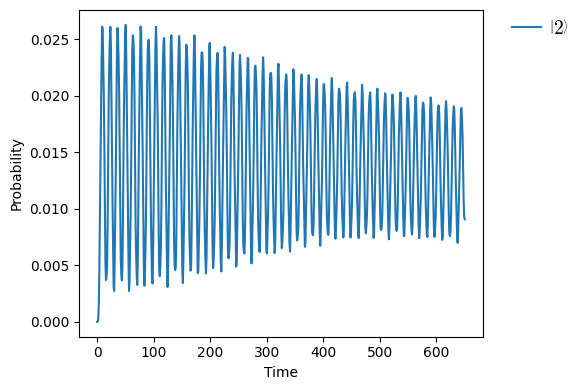

In [62]:
fig, ax = plt.subplots(dpi=100)

control_state = "2"
control_probs = np.zeros(len(eval_times), dtype=float)
for label in labels:
    if label[1] == control_state:
        control_probs += eval_probs[label]

ax.plot(
    eval_times, 
    control_probs, 
    label=f'$\\left|{control_state}\\right\\rangle$'
)
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

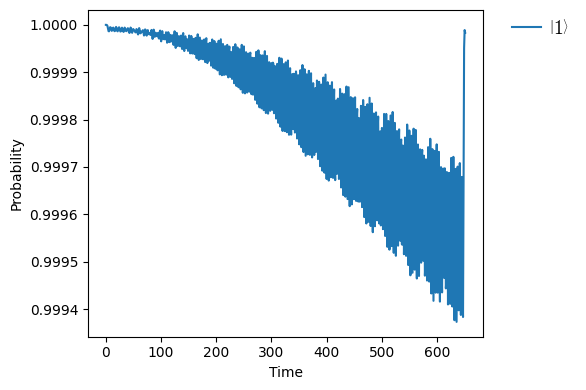

In [78]:
fig, ax = plt.subplots(dpi=100)

spec_state = "1"
spec_probs = np.zeros(len(eval_times), dtype=float)
for label in labels:
    if label[2] == spec_state:
        spec_probs += eval_probs[label]

ax.plot(
    eval_times, 
    spec_probs, 
    label=f'$\\left|{spec_state}\\right\\rangle$'
)
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

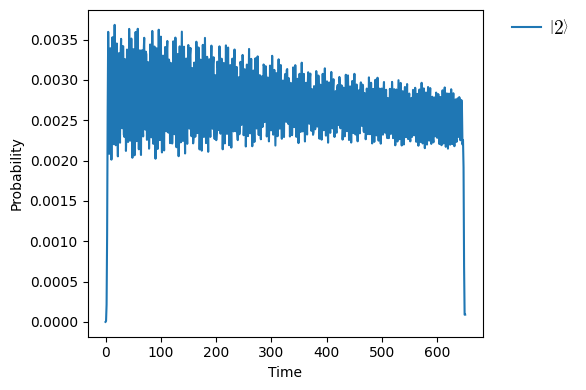

In [79]:
fig, ax = plt.subplots(dpi=100)

control_state = "2"
control_probs = np.zeros(len(eval_times), dtype=float)
for label in labels:
    if label[1] == control_state:
        control_probs += eval_probs[label]

ax.plot(
    eval_times, 
    control_probs, 
    label=f'$\\left|{control_state}\\right\\rangle$'
)
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

# Scans with transmon frequency

### Starting off with a general scan over wider range

In [23]:
spectator_freqs = np.linspace(4.65, 5.25, 41)
times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

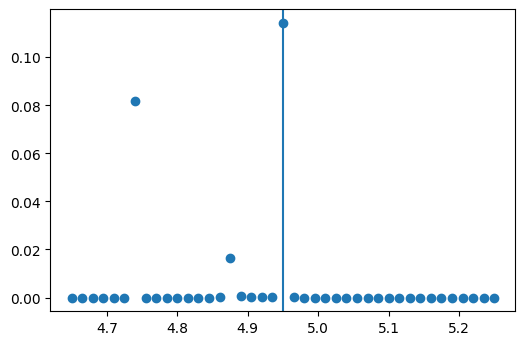

In [24]:
fig, ax = plt.subplots(dpi=100)

ax.scatter(spectator_freqs, leakage_rates)
ax.axvline(4.95)
plt.show()

### Detailed scan around the $f_{spec}^{0\rightarrow1} + f_{target}^{0\rightarrow1} = f_{control}^{0\rightarrow2}$ frequency collision

In [62]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 41

collision_cond = (2*control_transmon.freq + control_transmon.anharm) - target_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [103]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

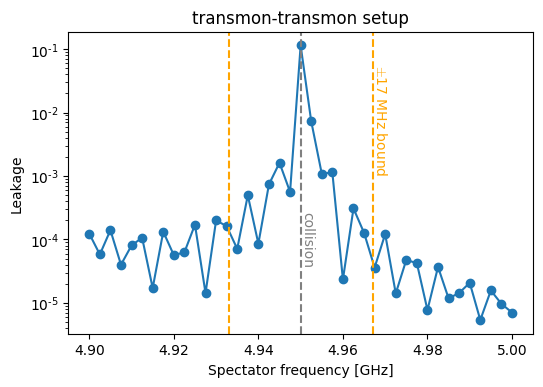

In [91]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(spectator_freqs, leakage_rates, linestyle="-", marker="o")
ax.axvline(collision_cond, linestyle = "--", color="grey")

ax.text(collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [108]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_control_02_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

### Detailed scan around the $f_{spec}^{0\rightarrow1} + f_{control}^{0\rightarrow1} = f_{target}^{0\rightarrow2}$ frequency collision

In [61]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 21

#collision_cond = (2*control_transmon.freq + control_transmon.anharm) - target_transmon.freq
collision_cond = 2*target_transmon.freq + TRANSMON_ANHARM - control_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [65]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

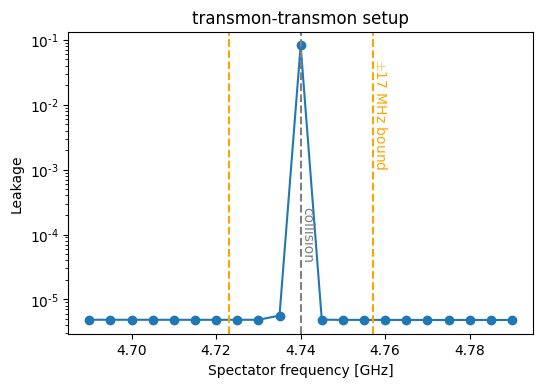

In [67]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [68]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_target_02_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

Enhance!

In [69]:
FREQ_RANGE = 0.005 # GHz
NUM_POINTS = 21

collision_cond = 2*target_transmon.freq + TRANSMON_ANHARM - control_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [70]:
detailed_leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

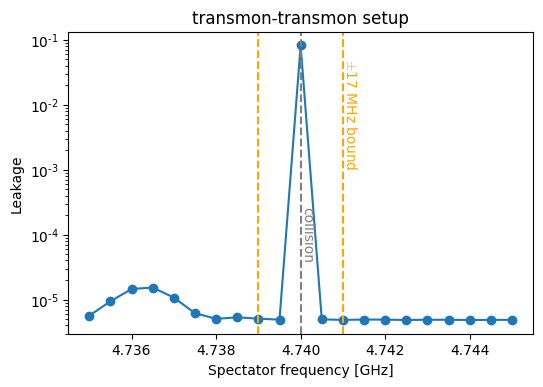

In [71]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.001

ax.plot(detailed_leakage_arr.spectator_freq, detailed_leakage_arr, linestyle="-", marker="o")
ax.axvline(detailed_leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(detailed_leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(detailed_leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(detailed_leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(detailed_leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [72]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_target_02_collision_detailed_scan.nc"
    detailed_leakage_arr.to_netcdf(data_folder / arr_name)

### Detailed scan around the $f_{spec}^{1 \rightarrow 2} = f_{target}^{0\rightarrow1}$ frequency collision

In [125]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 41

collision_cond = target_transmon.freq - TRANSMON_ANHARM
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [131]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

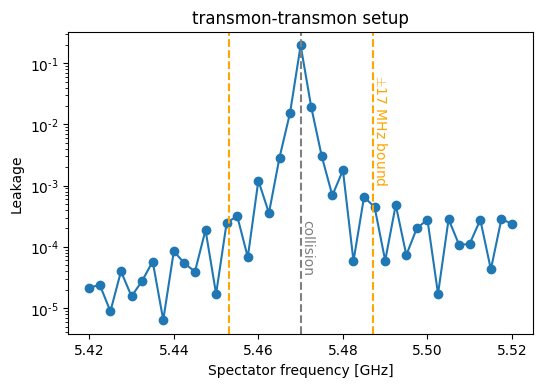

In [133]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [134]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_single_photon_spectator_12_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

### Detailed scan around the $f_{spec}^{0 \rightarrow 2} = 2f_{target}^{0\rightarrow1}$ frequency collision

In [136]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 41

collision_cond = target_transmon.freq - (0.5*TRANSMON_ANHARM)
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [137]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

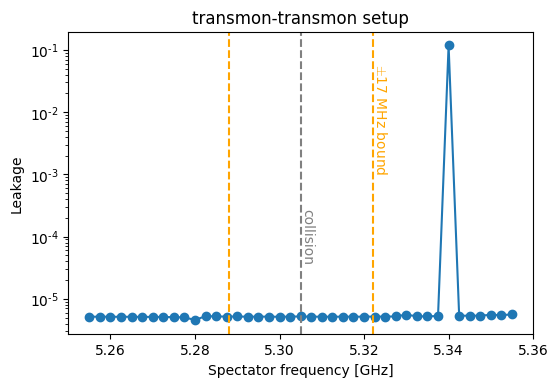

In [138]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [149]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 41

collision_cond = 0.5*(target_transmon.freq + control_transmon.freq - TRANSMON_ANHARM)
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [150]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

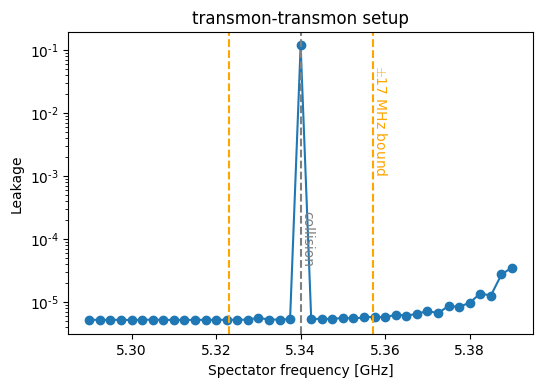

In [151]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [161]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_spectator_02_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

ENHANCE!

In [152]:
FREQ_RANGE = 0.005 # GHz
NUM_POINTS = 21

collision_cond = 0.5*(target_transmon.freq + control_transmon.freq - TRANSMON_ANHARM)
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [153]:
detailed_leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

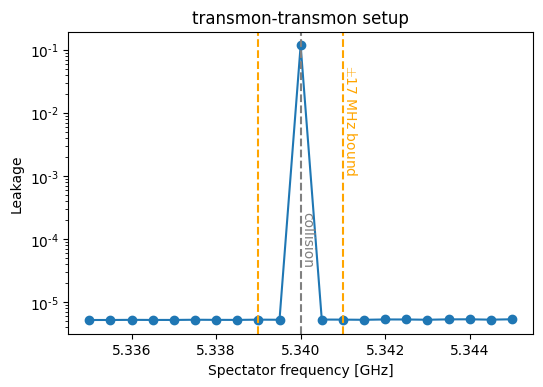

In [157]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.001

ax.plot(detailed_leakage_arr.spectator_freq, detailed_leakage_arr, linestyle="-", marker="o")
ax.axvline(detailed_leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(detailed_leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(detailed_leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(detailed_leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(detailed_leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [162]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_spectator_02_collision_detailed_scan.nc"
    detailed_leakage_arr.to_netcdf(data_folder / arr_name)